# Практическая работа 3 | Журавлев Александр Дмитриевич ББМО-02-23

Импортирование библиотек

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Загрузка уже обученной модели и данных MNIST для их использования в атаке

In [5]:
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат "one-hot encoded"
test_labels = to_categorical(test_labels, 10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9695 - loss: 0.1000
Test accuracy on clean images: 0.9761999845504761


Установка Foolbox

In [6]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00


Реализация атаки Carlini-Wagner

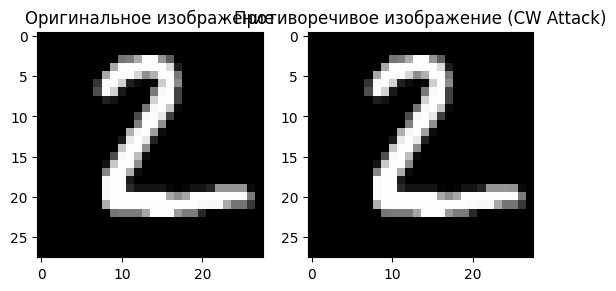

In [8]:
import foolbox as fb

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Извлечение изображения для атаки
image = tf.convert_to_tensor(test_images[1], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Выполнение атаки
attack = fb.attacks.L2CarliniWagnerAttack(steps=3)
tf.config.list_physical_devices('GPU')
adversarial_image = attack(fmodel, image, label[None], epsilons=0.1)

plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (CW Attack)")
plt.imshow(adversarial_image[0][0].numpy(), cmap="gray")
plt.show()


Оценка модели на противоречивых примерах

In [9]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []
for i in range(len(test_images) // 10): # ограничил выборку для ускорения выполнения
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)

# Оценка точности модели на противоречивых примерах
adversarial_images = tf.concat(adversarial_images, axis=0)
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:1000])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1056 - loss: 2.3915 
Accuracy on adversarial examples (CW attack): 0.09600000083446503
